In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import datetime
import torch 
import time

sys.path.append("../scripts")
from dataset_jpld import JPLD
from dataset_sequences import Sequences
from dataset_union import Union
from dataset_sunmoongeometry import SunMoonGeometry
from dataset_quasidipole import QuasiDipole
from dataset_celestrak import CelesTrak
from dataset_omniweb import OMNIWeb, omniweb_all_columns
from dataset_set import SET, set_all_columns
from graphcast_utils import sunlock_features, stack_features, circular_shift, get_subsolar_points
from torch.utils.data import DataLoader

date_start_ = datetime.datetime(2015, 1, 1)
date_end_ = datetime.datetime(2015, 1, 31)
date_exclusions_ = None
dataset_omniweb_dir = '/home/jupyter/data/omniweb_karman_2025'
dataset_celestrak_file_name = "/home/jupyter/data/celestrak/kp_ap_processed_timeseries.csv"
dataset_qd_dir = "/home/jupyter/data/quasi_dipole"
dataset_jpld_dir = "/home/jupyter/data/jpld/webdataset"
sunmoon = SunMoonGeometry(date_start=date_start_, date_end=date_end_, normalize=True, extra_time_steps=0)
quasidipole = QuasiDipole(data_dir=dataset_qd_dir, date_start=date_start_, date_end=date_end_, delta_minutes=15)
dataset_jpld = JPLD(dataset_jpld_dir, date_start=date_start_, date_end=date_end_,)

FIXED_CADENCE = 15 # mins
FIXED_IMAGE_SIZE = (180, 360) # (lat, lon)
aux_datasets = ["sunmoon", "quasidipole"] # "set" --- IGNORE ---
device = "cpu"


Sun and Moon Geometry
Start date              : 2015-01-01 00:00:00
End date                : 2015-01-31 00:00:00
Delta                   : 15 minutes
Image size              : (180, 360)
Extra time steps        : 0

Quasi Dipole Lat/Long coords
Start date              : 2015-01-01 00:00:00
End date                : 2015-01-31 00:00:00
Delta                   : 15 minutes
Note that all files are yearly, but treated as if given in delta_minutes cadence

JPLD
Directory      : /home/jupyter/data/jpld/webdataset
Rewind minutes : 50
Loading tar files index from cache: /home/jupyter/data/jpld/webdataset/tar_files_index_3a8334f288afd9deb25c6ec57c6b0cbb


Start date : 2015-01-01 00:00:00
End date   : 2015-01-31 00:00:00
Delta      : 15 minutes
Loading dates from cache: /home/jupyter/data/jpld/webdataset/dates_index_2015-01-01T00:00:00_2015-01-31T00:00:00
TEC maps total    : 2,880
TEC maps available: 2,880
TEC maps dropped  : 0


In [2]:
sample_time = datetime.datetime(2015, 1, 10, 0, 0)
tec_map = dataset_jpld[sample_time][0]
file_dir = "/home/jupyter/data/quasi_dipole/"
file_path_lat = os.path.join(file_dir, "qd_lat_2015.npy")
file_path_lon = os.path.join(file_dir, "qd_lon_2015.npy")
qd_lat = np.load(file=file_path_lat)
qd_lon = np.load(file=file_path_lon)

In [3]:
dataset_constructors = { # NOTE: changed the default column value for omniweb. Gunes says to use the default parser arg for args.omniweb_columns
        'sunmoon': lambda date_start_=None, date_end_=None, date_exclusions_=None, column_=None: SunMoonGeometry(date_start=date_start_, date_end=date_end_, normalize=True, extra_time_steps=0), # Note: no date_exclusions and also extra_time_steps should be 1 for IonCastGNN
        'omni': lambda date_start_=None, date_end_=None, date_exclusions_=None, column_=omniweb_all_columns: OMNIWeb(data_dir=dataset_omniweb_dir, date_start=date_start_, date_end=date_end_, normalize=True, date_exclusions=date_exclusions_, delta_minutes=FIXED_CADENCE, column=column_, return_as_image_size=FIXED_IMAGE_SIZE),
        # 'omni': lambda date_start_=None, date_end_=None, date_exclusions_=None, column_=omniweb_all_columns: OMNIWeb(data_dir=dataset_omniweb_dir, date_start=date_start_, date_end=date_end_, normalize=True, date_exclusions=date_exclusions_, delta_minutes=FIXED_CADENCE, column=column_, return_as_image_size=FIXED_IMAGE_SIZE),
        'celestrak': lambda date_start_=None, date_end_=None, date_exclusions_=None, column_=['Kp', 'Ap']: CelesTrak(file_name=dataset_celestrak_file_name, date_start=date_start_, date_end=date_end_, normalize=True, date_exclusions=date_exclusions_, delta_minutes=FIXED_CADENCE, column=column_, return_as_image_size=FIXED_IMAGE_SIZE),
        # 'set': lambda date_start_=None, date_end_=None, date_exclusions_=None, column_=set_all_columns: SET(file_name=dataset_set_file_name, date_start=date_start_, date_end=date_end_, normalize=True, date_exclusions=date_exclusions_, delta_minutes=FIXED_CADENCE,column=column_, return_as_image_size=FIXED_IMAGE_SIZE),
        'quasidipole': lambda date_start_=None, date_end_=None, date_exclusions_=None: QuasiDipole(data_dir=dataset_qd_dir, date_start=date_start_, date_end=date_end_, delta_minutes=FIXED_CADENCE),
    }

In [4]:
import skyfield.api

EPH = skyfield.api.load('de421.bsp')
SUN_BODY = EPH['sun']
EARTH_BODY = EPH['earth']
TS = skyfield.api.load.timescale()



In [5]:
dataset_jpld_train = JPLD(dataset_jpld_dir, date_start=date_start_, date_end=date_end_, date_exclusions=date_exclusions_)

# if 'sunmoon' in args.aux_datasets and args.sun_moon_extra_time_steps > 0:
#     raise ValueError(f'SunMoonGeometry dataset argument sun_moon_extra_time_steps={0} is not compatible with IonCastGNN model. Set sun_moon_extra_time_steps=0 for IonCastGNN.')

aux_datasets_train = [dataset_constructors[name](date_start_=date_start_, date_end_=date_end_, date_exclusions_=date_exclusions_) for name in aux_datasets]

print('Training sequence: ')
dataset_train = Sequences([dataset_jpld_train] + aux_datasets_train, delta_minutes=FIXED_CADENCE, sequence_length=96+12, dilation=1)    
train_loader = DataLoader(dataset_train, batch_size=3, shuffle=True, num_workers=1, pin_memory=True, persistent_workers=True, prefetch_factor=4)


JPLD
Directory      : /home/jupyter/data/jpld/webdataset
Rewind minutes : 50
Loading tar files index from cache: /home/jupyter/data/jpld/webdataset/tar_files_index_3a8334f288afd9deb25c6ec57c6b0cbb


Start date : 2015-01-01 00:00:00
End date   : 2015-01-31 00:00:00
Delta      : 15 minutes
Loading dates from cache: /home/jupyter/data/jpld/webdataset/dates_index_2015-01-01T00:00:00_2015-01-31T00:00:00
TEC maps total    : 2,880
TEC maps available: 2,880
TEC maps dropped  : 0

Sun and Moon Geometry
Start date              : 2015-01-01 00:00:00
End date                : 2015-01-31 00:00:00
Delta                   : 15 minutes
Image size              : (180, 360)
Extra time steps        : 0

Quasi Dipole Lat/Long coords
Start date              : 2015-01-01 00:00:00
End date                : 2015-01-31 00:00:00
Delta                   : 15 minutes
Note that all files are yearly, but treated as if given in delta_minutes cadence
Training sequence: 

Sequences
Start date              : 2015-01-01 00:00:00
End date                : 2015-01-31 00:00:00
Delta                   : 15 minutes
Sequence length         : 108
Sequence duration       : 1620 minutes
Dilation                : 1
Number of

In [6]:
sample = next(iter(train_loader))
# print(sample[0])
print(sample[-1].__len__(), sample[-1][0].__len__())
timestamps = sample[-1]

grid_nodes, image_inds = stack_features(
        sample[:-1], 
        image_size=FIXED_IMAGE_SIZE, 
        batched=True, # False when the batch dimension doesnt exist
    )

grid_nodes = grid_nodes.to(device)
grid_nodes = grid_nodes.float() # Ensure the grid nodes are in float32    

108 3


In [7]:
sample = dataset_train[0]
# print(sample[0])
print(sample[-1].__len__(), sample[-1][0].__len__())
timestamps = sample[-1]

grid_nodes, image_inds = stack_features(
        sample[:-1], 
        image_size=FIXED_IMAGE_SIZE, 
        batched=False, # False when the batch dimension doesnt exist
    )

grid_nodes = grid_nodes.to(device)
grid_nodes = grid_nodes.float() # Ensure the grid nodes are in float32    

108 19


In [20]:
print(grid_nodes.shape)

torch.Size([1, 108, 23, 180, 360])


In [8]:
print(dataset_train[0][-1])

['2015-01-01T00:00:00', '2015-01-01T00:15:00', '2015-01-01T00:30:00', '2015-01-01T00:45:00', '2015-01-01T01:00:00', '2015-01-01T01:15:00', '2015-01-01T01:30:00', '2015-01-01T01:45:00', '2015-01-01T02:00:00', '2015-01-01T02:15:00', '2015-01-01T02:30:00', '2015-01-01T02:45:00', '2015-01-01T03:00:00', '2015-01-01T03:15:00', '2015-01-01T03:30:00', '2015-01-01T03:45:00', '2015-01-01T04:00:00', '2015-01-01T04:15:00', '2015-01-01T04:30:00', '2015-01-01T04:45:00', '2015-01-01T05:00:00', '2015-01-01T05:15:00', '2015-01-01T05:30:00', '2015-01-01T05:45:00', '2015-01-01T06:00:00', '2015-01-01T06:15:00', '2015-01-01T06:30:00', '2015-01-01T06:45:00', '2015-01-01T07:00:00', '2015-01-01T07:15:00', '2015-01-01T07:30:00', '2015-01-01T07:45:00', '2015-01-01T08:00:00', '2015-01-01T08:15:00', '2015-01-01T08:30:00', '2015-01-01T08:45:00', '2015-01-01T09:00:00', '2015-01-01T09:15:00', '2015-01-01T09:30:00', '2015-01-01T09:45:00', '2015-01-01T10:00:00', '2015-01-01T10:15:00', '2015-01-01T10:30:00', '2015-01-0

In [9]:
B, T, C, H, W = grid_nodes.shape 
def get_subsolar_points(grid_nodes, timestamps, batched=True):
    """ 
    Calculate the subsolar point (latitude and longitude) for each timestamp in the batch.
    Inputs:
        grid_nodes: tensor of shape (B, T, C, H, W) to get the batch size and time steps.
        timestamps: list of list of timestamps of shape (T, B) in ISO format strings.
        batched: if True, grid_nodes has a batch dimension.
    Outputs:
        sub_lats: tensor of shape (B, T) with the latitude of the subsolar point in degrees.
        sub_lons: tensor of shape (B, T) with the longitude of the subsolar point in degrees.
    ------------------------------------------------------------------------------
    """
    B, T, C, H, W = grid_nodes.shape # note that even if batched=False, grid_nodes will still have a batch dimension of 1 since it is passed through stack_features already

    sub_lats = torch.empty((B, T))
    sub_lons = torch.empty((B, T))
    for b_idx in range(B):
        for t_idx in range(T):
            if batched:
                ts = timestamps[t_idx][b_idx]
            else:
                ts = timestamps[t_idx]
                
            utc_dt = datetime.datetime.strptime(ts, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=datetime.timezone.utc)
            # print(utc_dt)
            celestial_body = SUN_BODY 
            t = TS.from_datetime(utc_dt)

            astrometric = EARTH_BODY.at(t).observe(celestial_body)
            subpoint = skyfield.api.wgs84.subpoint_of(astrometric)

            sub_lats[b_idx, t_idx] = subpoint.latitude.degrees
            sub_lons[b_idx, t_idx] = subpoint.longitude.degrees
    return sub_lats, sub_lons
    
sub_lats, sub_lons = get_subsolar_points(grid_nodes, timestamps, batched=False)
print(sub_lats.shape, sub_lons.shape)

torch.Size([1, 108]) torch.Size([1, 108])


In [11]:
sub_lats.shape

torch.Size([1, 108])

In [36]:
print(grid_nodes.shape)
shifts = (sub_lons + 60) % 360

shifted_grid_nodes = circular_shift(grid_nodes.to("cuda:0"), shifts.to("cuda:0"), dim=-1)
print(shifted_grid_nodes.shape)

torch.Size([1, 108, 23, 180, 360])
torch.Size([1, 108, 23, 180, 360])


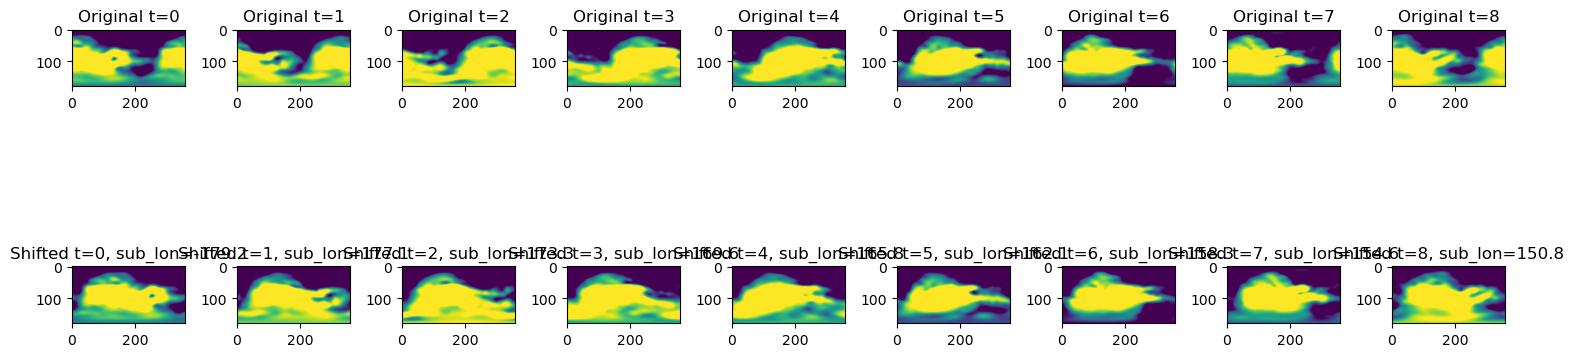

In [37]:
b_idx = 0
c_idx = 0
dilation = 12
# in subplots of 2 rows and T columns, plot the original and shifted images
fig, axs = plt.subplots(2, T//dilation, figsize=(15, 6))
for t_idx in range(T//dilation):

    axs[0, t_idx].imshow(grid_nodes[b_idx, t_idx*dilation, c_idx].to("cpu"), vmin=0, vmax=1)
    axs[0, t_idx].set_title(f'Original t={t_idx}')
    axs[1, t_idx].imshow(shifted_grid_nodes[b_idx, t_idx*dilation, c_idx].to("cpu"), vmin=0, vmax=1)
    axs[1, t_idx].set_title(f'Shifted t={t_idx}, sub_lon={sub_lons[b_idx, t_idx]:.1f}')
plt.tight_layout()
plt.show()

In [ ]:
print(grid_nodes.shape)
shifts = sub_lons + 60

shifted_grid_nodes = sunlock_features(grid_nodes.to("cpu"), sub_lats, sub_lons, latitude_lock=False)
print(shifted_grid_nodes.shape)

torch.Size([3, 96, 23, 180, 360])


torch.Size([3, 96, 23, 180, 360])


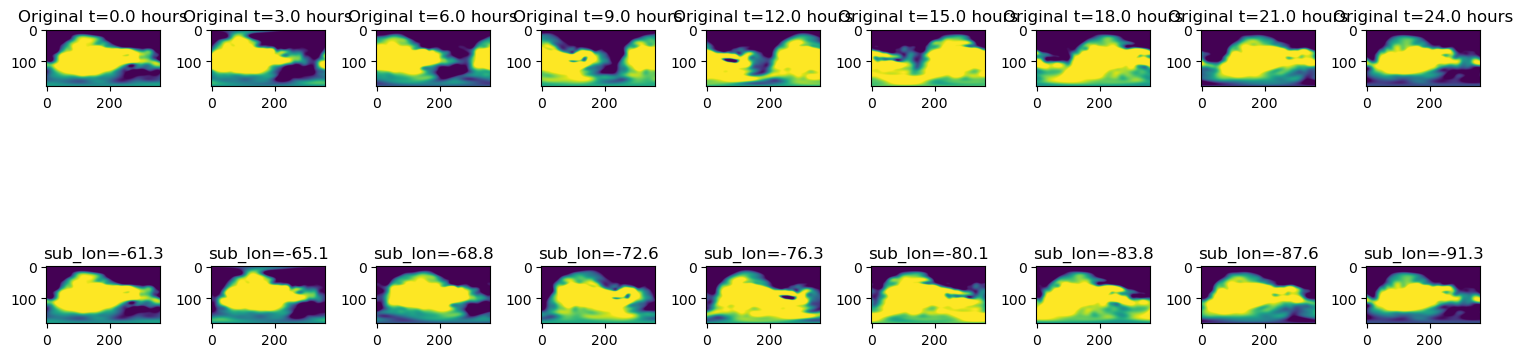

In [18]:
b_idx = 2
c_idx = 0
dilation = 12
# in subplots of 2 rows and T columns, plot the original and shifted images
fig, axs = plt.subplots(2, T//dilation, figsize=(15, 6))
for t_idx in range(T//dilation):

    axs[0, t_idx].imshow(grid_nodes[b_idx, t_idx*dilation, c_idx].to("cpu"), vmin=0, vmax=1)
    axs[0, t_idx].set_title(f'Original t={t_idx*dilation * 15 / 60} hours')
    axs[1, t_idx].imshow(shifted_grid_nodes[b_idx, t_idx*dilation, c_idx], vmin=0, vmax=1)
    axs[1, t_idx].set_title(f'sub_lon={sub_lons[b_idx, t_idx]:.1f}')
plt.tight_layout()
plt.show()

In [ ]:
1260 / 60

21.0

In [ ]:
12

In [ ]:
tec_map.shape

torch.Size([1, 180, 360])

In [ ]:
print(qd_lat.shape)

(180, 360)


In [ ]:
print(qd_lat.min(), qd_lat.max())
print(qd_lon.min(), qd_lon.max())

-89.66883850097656 89.60018157958984
-179.99630737304688 179.99298095703125


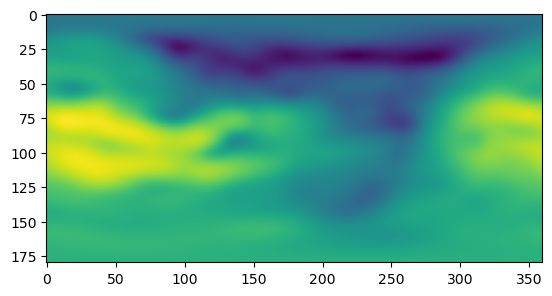

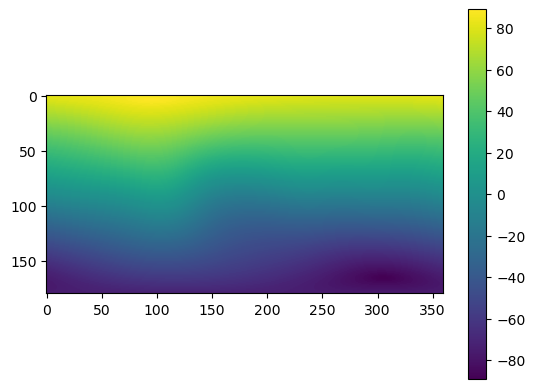

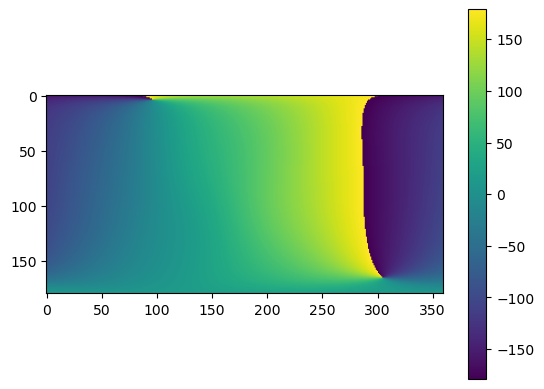

In [ ]:
plt.imshow(tec_map[0])
plt.show()
plt.imshow(qd_lat.astype(int))
plt.colorbar()
plt.show()
plt.imshow(qd_lon.astype(int))
plt.colorbar()
plt.show()

In [ ]:
qd_lon

array([[-167.3478241 , -167.19314575, -167.04304504, ..., -167.83840942,
        -167.67054749, -167.50698853],
       [-160.2517395 , -160.0113678 , -159.7754364 , ..., -160.99868774,
        -160.7454834 , -160.49647522],
       [-154.23880005, -153.91807556, -153.60116577, ..., -155.22320557,
        -154.89141846, -154.56326294],
       ...,
       [   3.23462319,    3.12040401,    3.0127418 , ...,    3.61719418,
           3.48296452,    3.35545826],
       [   7.01703501,    6.91494513,    6.81759501, ...,    7.3518858 ,
           7.23549414,    7.12388039],
       [  10.55664444,   10.47571659,   10.39787483, ...,   10.81788349,
          10.72773647,   10.64065456]], shape=(180, 360))

In [ ]:
import

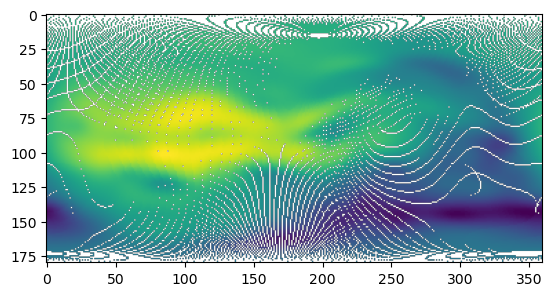

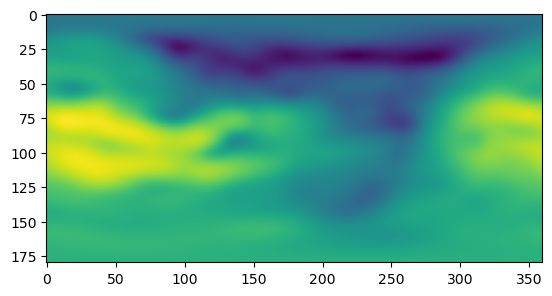

In [ ]:
tec_qd = np.full_like(tec_map[0], np.nan, dtype=float)

# Shift QD coords into array indices
lat_idx = qd_lat + 90      # map [-90,89] → [0,179]
lon_idx = qd_lon + 180     # map [-180,179] → [0,359]

# Fill in
tec_qd[lat_idx.astype(int), lon_idx.astype(int)] = tec_map
plt.imshow(tec_qd)
plt.show()
plt.imshow(tec_map[0])

In [ ]:
plt.imshow(tec_map[0][qd_lat.astype(int)+90, qd_lon.astype(int)+180])
plt.show()
plt.imshow(tec_map[0])

IndexError: index 180 is out of bounds for dimension 0 with size 180

In [ ]:
import apexpy


In [ ]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# Define the original lat/lon grid of tec_map
lats = np.linspace(-90, 90, tec_map.shape[0])   # 180 points
lons = np.linspace(-180, 180, tec_map.shape[1]) # 360 points

# Build interpolator for tec_map
interp = RegularGridInterpolator((lats, lons), tec_map.numpy(), bounds_error=False, fill_value=np.nan)

# Stack QD coordinates into (N,2) array
qd_points = np.stack([qd_lat.ravel(), qd_lon.ravel()], axis=-1)

# Interpolate to QD coords
tec_qd = interp(qd_points).reshape(*qd_lat.shape,  360)


In [ ]:
print(interp(qd_points).shape)
print(qd_points.shape)


(64800, 360)
(64800, 2)


In [ ]:
64800 / 180

360.0

In [ ]:
tec_qd

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

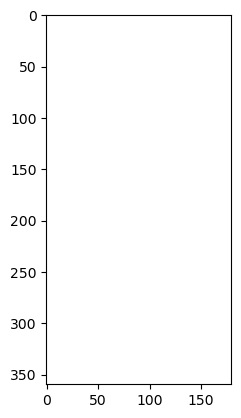

In [ ]:
plt.imshow(tec_qd[:,:,0])

In [ ]:
import numpy as np
from apexpy import Apex
# Initialize Apex object for a given epoch
apex = Apex(date=2020)
# Example: build a grid of geographic coordinates
# latitudes from -90 to 90 (180 points), longitudes from 0 to 360 (360 points)
lons = np.linspace(0, 360, 360, endpoint=False)
lats = np.linspace(-90, 90, 180)
lon_grid, lat_grid = np.meshgrid(lons, lats, indexing='ij')
# Altitude in km
alt_km = 300.0  
# Convert the whole grid to quasi-dipole coordinates
qd_lat, qd_lon = apex.convert(lat_grid, lon_grid, 'geo', 'qd', height=alt_km)
print("Quasi-dipole lat shape:", qd_lat.shape)
print("Quasi-dipole lon shape:", qd_lon.shape)

Quasi-dipole lat shape: (360, 180)
Quasi-dipole lon shape: (360, 180)


In [ ]:
from scipy.interpolate import griddata
import numpy as np

# Original grid coordinates
glat = np.linspace(-90, 90, tec_map.shape[0])
glon = np.linspace(-180, 180, tec_map.shape[1])
GLON, GLAT = np.meshgrid(glon, glat)

# Flatten
points_geo = np.stack([qd_lat.ravel(), qd_lon.ravel()], axis=-1)  # QD coords of each geo gridpoint
values = tec_map.ravel()

# Define target QD grid
qd_lat_new = np.linspace(-90, 90, 180)
qd_lon_new = np.linspace(-180, 180, 360)
QDLON_new, QDLAT_new = np.meshgrid(qd_lon_new, qd_lat_new)

# Interpolate into QD grid
tec_qd = griddata(points_geo, values,
                  (QDLAT_new, QDLON_new),
                  method='linear')


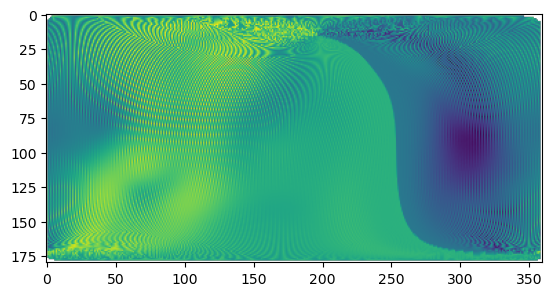

In [ ]:
plt.imshow(tec_qd)

TypeError: Dimensions of C (360, 180) should be one smaller than X(360) and Y(180) while using shading='flat' see help(pcolormesh)

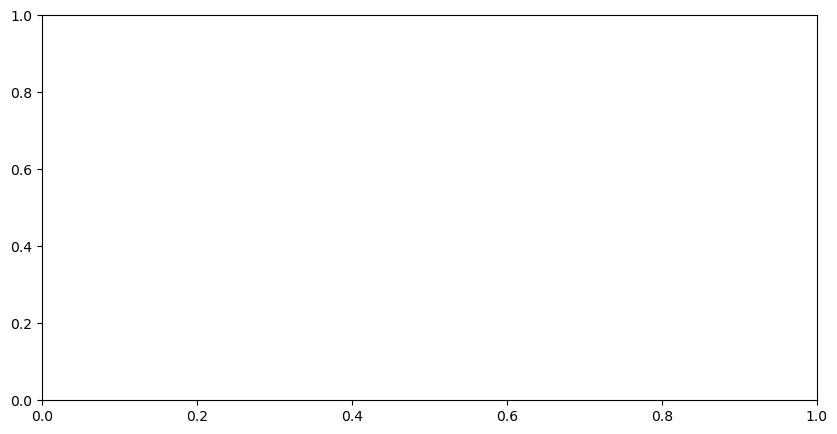

In [ ]:
from scipy.interpolate import griddata
# Flatten inputs for interpolation
points = np.column_stack((qd_lon.flatten(), qd_lat.flatten()))
values_flat = tec_map.flatten()
# Define target regular magnetic grid
mlon = np.linspace(0, 360, 360)
mlat = np.linspace(-90, 90, 180)
mlon_grid, mlat_grid = np.meshgrid(mlon, mlat, indexing='ij')
# Interpolate
values_mag = griddata(points, values_flat, (mlon_grid, mlat_grid), method='linear')
# Plot with pcolormesh
plt.figure(figsize=(10,5))
plt.pcolormesh(mlon, mlat, values_mag.T, cmap="viridis", shading="auto")
plt.colorbar(label="Value")
plt.xlabel("Magnetic Longitude (deg)")
plt.ylabel("Magnetic Latitude (deg)")
plt.title("Values on Regular Quasi-Dipole Grid")
plt.show()

Quasi-Dipole Latitude (degrees):
[[-74.515625   -73.94123077 -73.33908844 ...  84.36560059  84.54362488
   84.50450134]
 [-74.515625   -73.95458221 -73.36468506 ...  84.33570099  84.52813721
   84.50450134]
 [-74.515625   -73.96810913 -73.390625   ...  84.30596161  84.51266479
   84.50450134]
 ...
 [-74.515625   -73.90220642 -73.26437378 ...  84.45623016  84.59021759
   84.50450134]
 [-74.515625   -73.91503906 -73.28892517 ...  84.4258728   84.57466888
   84.50450134]
 [-74.515625   -73.92804718 -73.31383514 ...  84.3956604   84.55914307
   84.50450134]]
Quasi-Dipole Longitude (degrees):
[[ 18.24465179  21.06889534  23.67027092 ... 147.47080994 158.72958374
  170.29550171]
 [ 18.24465179  21.10754395  23.74895668 ... 147.55670166 158.74284363
  170.29550171]
 [ 18.24465179  21.14541626  23.82632637 ... 147.64819336 158.75950623
  170.29550171]
 ...
 [ 18.24465179  20.94841194  23.42656708 ... 147.24783325 158.7106781
  170.29550171]
 [ 18.24465179  20.98931694  23.50905037 ... 147.3162

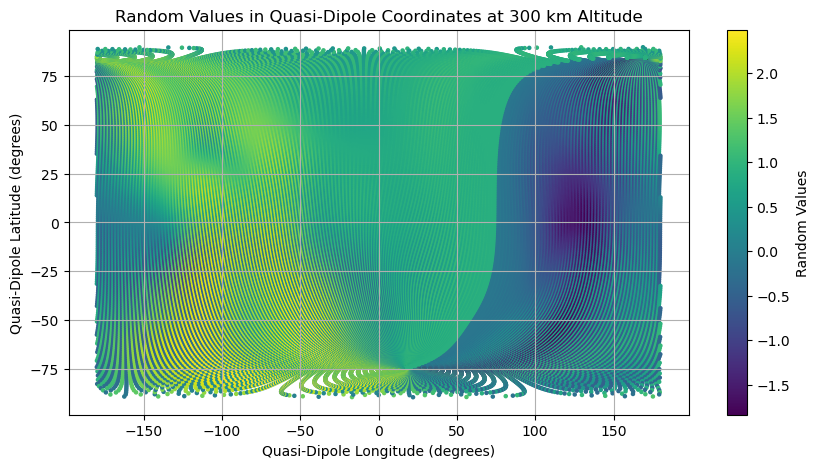

In [ ]:
from apexpy import Apex
import numpy as np
apex = Apex(date="2024")
lons = np.linspace(0, 360, 360, endpoint= False)
lats = np.linspace(-90, 90, 180)
lon_grid, lat_grid = np.meshgrid(lons, lats, indexing="ij")
alt_km = 110  # Altitude in kilometers
qd_lat, qd_lon = apex.convert(lat_grid, lon_grid, 'geo', 'qd', alt_km)
print("Quasi-Dipole Latitude (degrees):")
print(qd_lat)
print("Quasi-Dipole Longitude (degrees):")
print(qd_lon)
import matplotlib.pyplot as plt
values = tec_map.numpy()
plt.figure(figsize=(10,5))
sc = plt.scatter(qd_lon, qd_lat, c=values, s=5, cmap='viridis')
plt.colorbar(sc, label='Random Values')
plt.xlabel('Quasi-Dipole Longitude (degrees)')
plt.ylabel('Quasi-Dipole Latitude (degrees)')
plt.title('Random Values in Quasi-Dipole Coordinates at 300 km Altitude')
plt.grid(True)
plt.show()

360 180


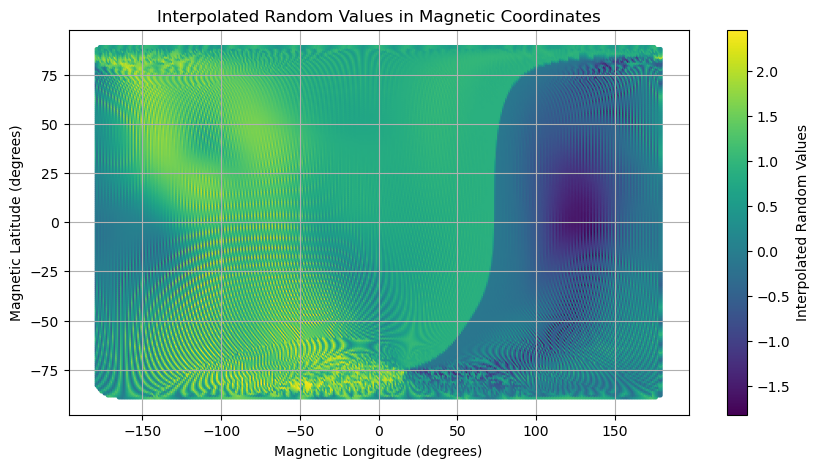

In [ ]:
from scipy.interpolate import griddata
points = np.column_stack((qd_lon.flatten(), qd_lat.flatten()))
values_flat = values.flatten()
mlon = np.linspace(-180, 180, 360)
mlat = np.linspace(-90, 90, 180)
mlon_grid, mlat_grid = np.meshgrid(mlon, mlat, indexing="ij")
values_mag = griddata(points, values_flat, (mlon_grid, mlat_grid), method='linear')
print(len(values_mag), len(values_mag[0]))
plt.figure(figsize=(10,5))
sc = plt.scatter(mlon_grid, mlat_grid, c=values_mag, s=5, cmap='viridis')
plt.colorbar(sc, label='Interpolated Random Values')
plt.xlabel('Magnetic Longitude (degrees)')
plt.ylabel('Magnetic Latitude (degrees)')
plt.title('Interpolated Random Values in Magnetic Coordinates')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import griddata

# tec_map: shape (180, 360)
# qd_lat, qd_lon: shape (180, 360), float values (not integers)

# Flatten the original mapping
points_qd = np.stack([qd_lat.ravel(), qd_lon.ravel()], axis=-1)  # QD coords
values = tec_map.ravel()

# Define a *regular QD grid* you want to interpolate onto
qd_lat_new = np.linspace(-90, 90, 180)
qd_lon_new = np.linspace(-180, 180, 360)
QDLON_new, QDLAT_new = np.meshgrid(qd_lon_new, qd_lat_new)

# Interpolate tec_map values from scattered QD coords -> regular QD grid
tec_qd = griddata(points_qd, values, (QDLAT_new, QDLON_new), method='linear')

# # tec_qd.shape = (180, 360)
# plt.imshow(tec_qd)